# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [6]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

In [8]:
f1(6,7)

171.0

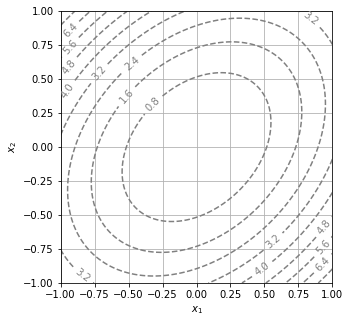

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [10]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

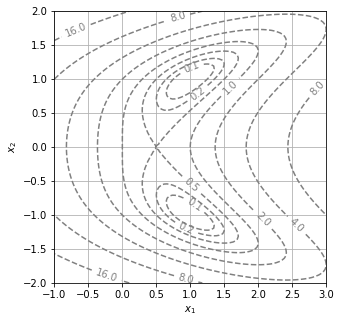

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

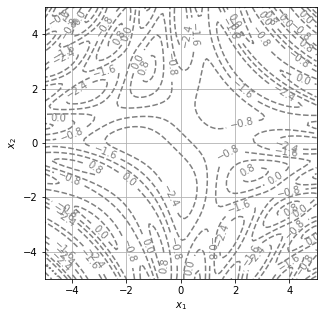

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

In [14]:
# création de fonctions utilisées par la suite

# fonction pour passer f de R² dans R² avec comme contrainte x=y
def F_x_egal_y(f):
    
    def F(x, y):
        a = f(x, y)
        return (a, y-x)
    return F

# idem mais ici la distance à (x0, y0) doit valoir delta
def F_delta(f, x0, y0 ,delta):
    
    def F(x, y):
        return (f(x, y), np.sqrt((x-x0)**2+(y-y0)**2)-delta)
    return F

# fonction pour faire varier la valeur de la ligne de niveau souhaitée
def niveau(f, x, y, c):
    
    def F(x, y):
        a, b = f(x, y)
        a = a-c
        return np.array([a, b])
    return F

 # fonction retournant un vecteur "tourné" de pi/2
def rotation(vecteur):
    mat = [[0, 1], [-1, 0]]
    return np.dot(mat, vecteur)

# fonction du cercle unité
def cercle(x, y):
    return np.sqrt(x**2+y**2)

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [15]:
N = 100
eps = 10**-2

# Il faut une assez bonne précision car on itère Newton donc si erreur ->
# accumulation d erreurs à chaque appel de la fct
# et à la fin la ligne de niveau ne sera pas correcte du tout

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [16]:
def Newton(f, x0, y0, c, eps = eps, N = N):
    F = niveau(f, x0, y0, c)
    for i in range(N):
        t0 = np.array([x0, y0])
        J_F = J(F)
        t = F(x0, y0)
        A = np.linalg.solve(J_F(x0, y0), t)
        tnew = t0 - A
        x, y = tnew[0], tnew[1]
        if np.sqrt((x-x0)**2 + (y-y0)**2) <= eps:
            return (x, y)
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [17]:
x0, y0, c = 0.8, 0.8, 0.8

In [18]:
Newton(F_x_egal_y(f1), x0, y0, c, eps, N)

(0.447250250297228, 0.447250250297228)

In [19]:
def graph_variation_depart(f, c, eps, N):
    X = np.linspace(0.1, 10, 100)
    res = Newton(F_x_egal_y(f), 0.8, 0.8, c, eps, N)[0]
    Y = [abs(
        res-Newton(F_x_egal_y(f), x, x, c, eps, N)[0]
        ) for x in X]
    
    plt.plot(X, Y)
    plt.title('Ecart en fonction du point de départ')
    plt.show();

def graph_variation_niveau(f, x, y, eps, N):
    X = np.linspace(0.1, 10, 100)
    Y = [Newton(F_x_egal_y(f), x, y, c, eps, N)[0] for c in X]
    
    plt.plot(X, Y)
    plt.title('Solution en fonction du niveau recherché')
    plt.show();

def graph_variation_eps(f, x, y, c, N):
    X = np.linspace(0.01, 1, 50)
    res = Newton(F_x_egal_y(f), x, x, c, 0.01, N)[0]
    Y = [abs(
        res-Newton(F_x_egal_y(f), x, x, c, eps, N)[0]
        ) for eps in X]
    
    plt.plot(X, Y)
    plt.title('Ecart en fonction de epsilon')
    plt.show();

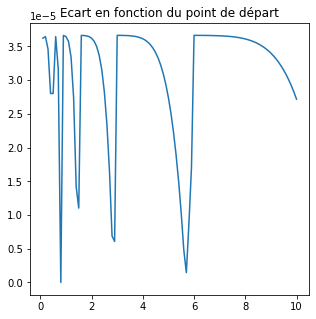

In [20]:
graph_variation_depart(f1, 0.8, eps, N)

In [21]:
# Ecarts faibles de l'ordre de 10**-5 devant la solution
# en 10**-1
# Même pour un point de départ éloigné,
# la convergence est efficace

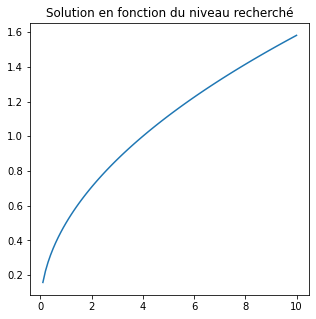

In [22]:
graph_variation_niveau(f1, 0.8, 0.8, eps, N)

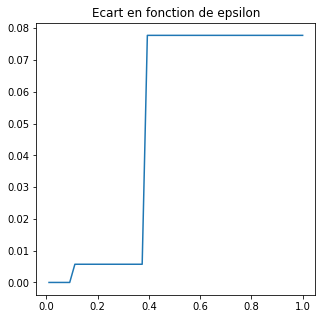

In [23]:
graph_variation_eps(f1, 0.8, 0.8, 0.8, N)

In [24]:
# Logiquement, plus epsilon est faible, plus on est précis
# Mais la dépendance précision-epsilon n'est pas linéaire 
# et a des valeurs seuils (not en 0.4)

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [25]:
# Si on note O = (x0, y0), on fabrique le vecteur normé
# V1 à partir d'une rotation de pi/2 à du vecteur gradient,
# et on se place au point O +V1*𝛿

def level_curve1(f, x0, y0, c, delta=0.1, N=1000, eps=eps):
    listepoints = np.empty((N,2))
    listepoints[0] = [x0, y0]
    grad_f = grad(f)
    for i in range (N):
        gradient = grad_f(x0, y0)
        gradientnorme = gradient/(np.linalg.norm(gradient))
        V1 = rotation(gradientnorme)
        x1, y1 = [x0, y0]  + delta * V1
        x0, y0 = Newton(F_delta(f, x0, y0, delta), x1, y1, c)
        listepoints[i] = [x0, y0]
    return listepoints

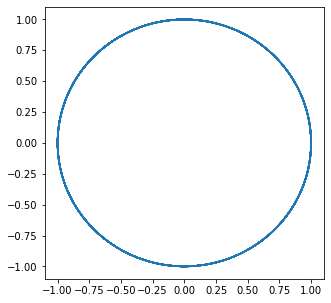

In [26]:
L=level_curve1(cercle, 1.0, 0.0, 1)

plt.plot(L[:,0], L[:,1])
plt.show();

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [27]:
def level_curve2(f, x0, y0, c, delta=0.1, N=1000, eps=eps):
    listepoints = np.empty((N,2))
    listepoints[0] = [x0, y0]
    xi, yi = x0, y0
    grad_f = grad(f)
    for i in range (1, N):
        gradient = grad_f(x0, y0)
        gradientnorme = gradient/(np.linalg.norm(gradient))
        V1 = rotation(gradientnorme)
        x1, y1 = [x0, y0]  + delta * V1
        x0, y0 = Newton(F_delta(f, x0, y0, delta), x1, y1, c)
        if (np.sqrt((xi-x0)**2+(yi-y0)**2)) <= delta and i>1:
            listepoints[i] = [xi, yi]
            return listepoints[:i+1]
        listepoints[i] = [x0, y0]
    raise ValueError(f"no looping in {N} steps.")

# ne marche pas si le point initial est un point
# de croisement de la courbe on pourrait conditionner
# avec le gradient pour régler ce problème

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

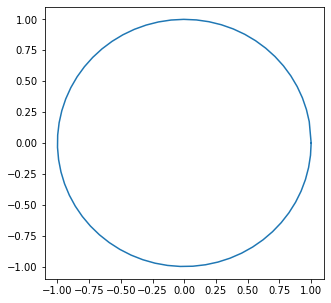

In [28]:
L=level_curve2(cercle, 1.0, 0.0, 1)

plt.plot(L[: , 0], L[: , 1])
plt.show();

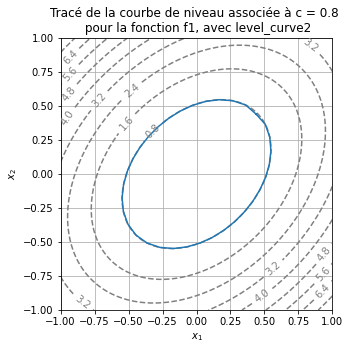

In [29]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100),
    y=np.linspace(-1.0, 1.0, 100),
    levels=10
)
L = level_curve2(f1, 0.44,0.44, 0.8)
plt.plot(L[: , 0], L[: , 1])
plt.title('Tracé de la courbe de niveau associée à '
          'c = 0.8 \n pour la fonction f1, avec level_curve2')
plt.show()

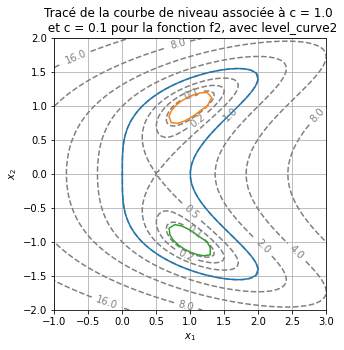

In [30]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100),
    y=np.linspace(-2.0, 2.0, 100),
    levels=[2**i for i in range(-3, 8)]
)
L = level_curve2(f2, 0.,0., 1.)
l1 = level_curve2(f2, 1.25, 1., 0.1)
l2 = level_curve2(f2, 1.25, -1., 0.1)
plt.plot(L[: , 0], L[: , 1])
plt.plot(l1[: , 0], l1[: , 1])
plt.plot(l2[: , 0], l2[: , 1])
plt.title('Tracé de la courbe de niveau associée à '
          'c = 1.0 \n et c = 0.1 pour la fonction f2, avec level_curve2')

plt.show()

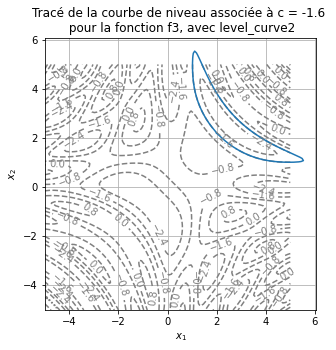

In [31]:
display_contour(
    f3,
    x=np.linspace(-5.0, 5.0, 100),
    y=np.linspace(-5.0, 5.0, 100),
    levels=5,
)
L = level_curve2(f3, 2., 2.2, -1.6)
plt.plot(L[: , 0], L[: , 1])
plt.title('Tracé de la courbe de niveau associée à ' 
          'c = -1.6 \n pour la fonction f3, avec level_curve2')
plt.show()

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [32]:
gauche = -3
droite = 2
haut = 2
bas = -2

In [33]:
def area_squares(f, c, h):
    abscissescarre = np.arange(gauche, droite, h)
    ordonnescarre = np.arange(bas, haut, h)
    n, m = len(abscissescarre)-1, len(ordonnescarre)-1
    appartenance = np.zeros((m, n))
    for i in range (n):
        for j in range (m):
            xh , yh = abscissescarre[i] + h/2, ordonnescarre[j] + h/2
            appartenance[j, i] = (f(xh, yh)<=c)
    aire = np.sum(appartenance) * h**2
    return aire

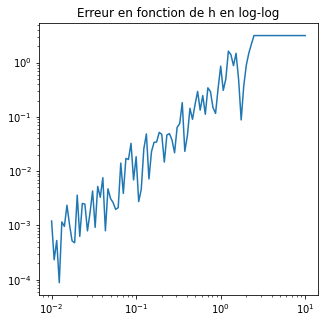

In [34]:
X = np.logspace(-2, 1, 100)
Y = [abs(area_squares(cercle, 1.0, x)-np.pi) for x in X]

plt.plot(X, Y)
plt.loglog()
plt.title('Erreur en fonction de h en log-log')
plt.show();

In [35]:
# la précision augmente quand h diminue
# diminution saccadée car h varie discrètement

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [36]:
def encadrement_carre(f, c, h, precision):
# première lignes identiques à celles de area_squares car on construit la grille des 1
    abscissescarre = np.arange(gauche, droite, h)
    ordonnescarre = np.arange(bas, haut, h)
    nombrecarres = 0
    n, m = len(abscissescarre)-1, len(ordonnescarre)-1
    appartenance = np.zeros((m, n))
    for i in range (n):
        for j in range (m) :
            xh , yh = abscissescarre[i] + h/2, ordonnescarre[j] + h/2 
            appartenance[j, i] = (f(xh, yh)<=c)
# modification de la grille pour majorer et minorer
    for x in np.argwhere(appartenance == 1):
        i, j = x[0], x[1]
        voisins = [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]
        for y in voisins: 
            nombrevoisinsdehors = 0
            if appartenance[y[0], y[1]] == 0:
# pour chaque voisin, on regarde si il "vaut" 0 donc si il est à l'extérieur
# dans ce cas la il prend la valeur 2 et son voisin dedans prend 3
                appartenance[y[0], y[1]] = 2
                appartenance[i, j] = 3
# les cases à l'intérieur et à plus d'une case du bord de la courbe valent toujours 1
# celles à la limite (dedans mais qui ont un voisin dehors) valent 3
# celles dehors mais proches du bord (sont voisins d'une case dedans) valent 2
# la minoration est l'aire de la surface des carrés largement dedans (donc qui valent 1)
# la majoration est l'aire de la surface intérieur (1 + 2) et de ceux dehors proches du bord (3)
    airemaj = (np.sum(appartenance >= 1)) * (h**2)
    airemin = (np.sum(appartenance == 1)) * (h**2)
    h = h
    while airemaj - airemin > precision:
        h = h/2
        airemin, airemaj = encadrement_carre(f, c, h, precision)
    return airemin, airemaj


In [37]:
encadrement_carre(cercle, 1, 0.5, 0.1)

(3.102783203125, 3.185791015625)

In [38]:
#encadrement_carre(cercle,1,0.05, 0.01)  trop long à éxecuter

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [39]:
def aire_triangle(T, p):
    aire = 0
    nbpoints = len(T)
    x0 , y0 = T[0]
    xf , yf = T[-1]
    xp , yp = p
    A = np.array([[xp-x0], [yp-y0]])
    B = np.array([[xp-xf], [yp-yf]])
    aire += np.cross(B.T, A.T)[0]/2 # pour le triangle formé de l[0],l[-1] et p
    for i in range(1,nbpoints):
        x1, y1 = T[i]
        B = np.array([[xp-x1], [yp-y1]])
        aire += np.cross(A.T, B.T)[0]/2  # pour tous les autres triangles
        A = B
    return abs(aire)

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [40]:
import random

In [41]:
# pour tester les erreurs avec 10 points p
# aléatoires dans[-100,100]² avec le cercle unité
# et (0,0)

L= level_curve2(cercle, 1.0, 0.0, 1)
print(abs(np.pi-aire_triangle(L, (0, 0))))
for k in range(10):
    i, j = random.randint(-100, 100), random.randint(-100, 100)
    print(abs(np.pi-aire_triangle(L, (i, j))))

# le comportement ne change pas car avec le produit vectoriel,
# certaines aires sont comptées négativement
# et sont compensées sur la partie exterieure à la surface
# par d'autres produits vectoriels  

0.0055362128183267245
0.005536212818423536
0.005536212816092956
0.005536212818335606
0.0055362128176845715
0.0055362128176845715
0.005536212818480379
0.005536212818338271
0.0055362128183666925
0.005536212817911945
0.005536212818594066


**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

3.6675385585068123
3.6675385585061804
3.6675385585053846
3.667538558506749
3.6675385585068625
3.6675385585076583
3.6675385585066493
3.667538558506976
3.667538558507431
3.667538558506692
3.667538558506294


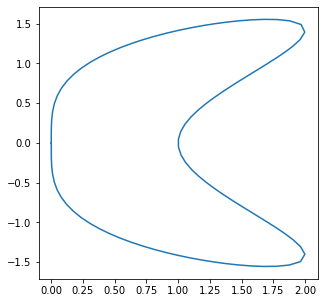

In [42]:
# pour f2 et la ligne de niveau 1.0 qui forme un ensemble non convexe

L = level_curve2(f2, 0.,0., 1.)
plt.plot(L[: , 0], L[: , 1])

print(abs(aire_triangle(L, (0, 0))))
for k in range(10):
    i, j = random.randint(-100, 100), random.randint(-100, 100)
    print(abs(aire_triangle(L, (i, j))))

plt.show();

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [43]:
def area_triangles(x, y):
    aire = 0
    nbpoints = len(x)
    A = np.array([[x[0]], [y[0]]])
    B = np.array([[x[-1]], [y[-1]]])
    # pour le triangle formé du dernier et premier point et (0,0)
    aire += np.cross(B.T, A.T)[0]/2
    for i in range(1,nbpoints):
        B = np.array([[x[i]], [y[i]]])
        aire += np.cross(A.T, B.T)[0]/2  # pour tous les autres triangles
        A = B
    return abs(aire)

In [44]:
L= level_curve2(cercle, 1.0, 0.0, 1)
print(abs(np.pi-area_triangles(L[: ,0], L[: ,1])))

0.0055362128183267245


In [45]:
import time

def comparaison_resultat(f, x, y, c, h):
    L = level_curve2(f, x, y, c)
    return abs(
        area_triangles(L[: ,0], L[: ,1])-area_squares(f, c, h)
        )

def comparaison_temps(f, x, y, c, h):
    L = level_curve2(f, x, y, c)
    start1 = time.time()
    area_squares(f, c, h)
    end1 = time.time()
    
    start2 = time.time()
    area_triangles(L[: ,0], L[: ,1])
    end2 = time.time()
    
    return(f" Temps pour les triangles :{end2-start2}, contre {end1-start1} pour les carrés")

In [46]:
# écart relatif pour le cercle unité
comparaison_resultat(cercle, 1., 0., 1, 0.01)/np.pi

0.002146541570508267

In [47]:
# écart pour f2
comparaison_resultat(f2, 0.,0., 1., 0.01)

0.0030614414931879885

In [48]:
# Les écarts obtenus sont relativement faibles

In [49]:
comparaison_temps(cercle, 1., 0., 1, 0.01)

' Temps pour les triangles :0.015630245208740234, contre 1.3558411598205566 pour les carrés'

In [50]:
# Temps de calcul pour les carrés nettement plus élevé

In [51]:
# Pour la méthode des triangles,
# on doit calculer les points de la ligne de niveau,
# pour augmenter la précision on doit recalculer 
# les pointse de manière plus précise, ce qui est
# désavantageant et n'est pas le cas pour les carrés

# Pour la méthode des carrés,
# les temps de calculs peuvent être longs,
# mais très pratique si on ne peut pas connaître
# la ligne de niveau

# Les deux méthodes fonctionnent pour des formes compliquées 
# (si on donne les points de la forme compliquée pour les triangles,
# qui ne sont pas toujours évident à trouver si "très convexe",
# exemple : f3)

# Conclusion :
# pour une ligne de niveau "simple", la méthode
# des triangles est préférable, mais sinon celle des carrés
# est plus passe-partout mais plus longs calculs